## Dynamic Traffic Assignments: DUO, DUE, DSO


WIP

There are 3 famous route choice principles for dynamic traffic assignments (DTA) (the definition varies depending on the terminology).

- Dynamic User Optimal (DUO): Travelers choose the shortest path based on the instantaneous travel time (the current average speed). 
- Dynamic User Equilibrium (DUE): Travelers choose the shortest path based on the actual travel time. 
- Dynamic System Optimal (DSO): Travelers choose the path so that the total travel time is minimized.

The important point of DTA is that travel time may change as the time progresses. 
Therefore, in the DUO, the chosen route may turn out not to be the actual shortest path after the traveler completes their trip, as the travel time may change during their trip.
Similarly, in the DUE, the "actual travel time" is unknown when the traveler choose the route, as it depends on the future travel time.
Likewise, in the DSO, it is not obvious which path minimizes the total travel time.

The default routing principle of UXsim is based on DUO, because it is reasonable and very easy to compute.

DUE and DSO are also important as theoretical benchmarks. 
Due to the aforementioned complexity, it is known that they are difficult to solve especially when the network is large. 
But, for small or mid scale networks with relatively small number of platoons, their approximate solutions can be obtained by UXsim. 
The solvers for DTA problems are implemented as `uxsim.DTAsolvers` submodule.
In this notebook, we demonstrate their behaviors.

Techical notes for experienced readers.
In this demonstration, we consider the route choice problem only. In the other words, we do not consider the departure time problem, and the departure time of each traveler is assumed to be fixed.


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
from pylab import *
import uxsim
from uxsim.DTAsolvers import *

### Two route network with parallel highway and arterial

We simulate a simple toy network with a route choice option. In order to use the identical scenario in multiple simulations efficiently, we define the following function that setup a World object with the identical conditions.

In [11]:
# scenario definition
def create_World():
    """
    A function that returns World object with scenario informaiton. This is faster way to reuse the same scenario, as `World.copy` or `World.load_scenario` takes some computation time.
    """
    W = uxsim.World(
        name="",
        deltan=20,
        tmax=6000,
        print_mode=0, save_mode=1, show_mode=1,
        vehicle_logging_timestep_interval=1, 
        hard_deterministic_mode=False,
        random_seed=42
    )

    W.addNode("1", 0, 1)
    W.addNode("2", 1, 1)
    W.addNode("3", 5, 1)
    W.addNode("4", 0, 0)
    W.addNode("5", 1, 0)
    W.addNode("6", 5, 0)
    W.addNode("7", 6, 0.5)

    W.addLink("highway12", "1", "2", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("highway23", "2", "3", length=3000, number_of_lanes=1, merge_priority=1, capacity_out=0.6)
    W.addLink("highway37", "3", "7", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("onramp", "5", "2", length=1000, number_of_lanes=1, merge_priority=0.5)
    W.addLink("arterial45", "4", "5", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial56", "5", "6", length=3000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial67", "6", "7", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)

    W.adddemand("1", "7", 0, 3000, 0.3)
    W.adddemand("4", "7", 0, 3000, 0.4*3)

    return W

The network structure is as follows. Vehicles travel from nodes "1" and "4" at the left to node "7" at the right. The upper route is a *highway*, and the bottom is an *arterial road*. The highway has faster maximum speed but smaller traffic capacity compared with the arterial road. 
Vehicles from "3" can choose either highway or arterial, depending on the traffic condition. 

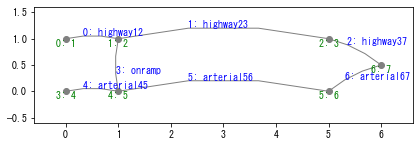

In [12]:
W = create_World()
W.show_network()

Furthermore, we define the following visualization function to visualize simulation results.

In [13]:
def visualizaion_helper_function(W):
    W.analyzer.print_simple_stats(force_print=True)
    W.analyzer.network_average()

    r1 = W.defRoute(["arterial45", "onramp", "highway23", "highway37"])
    r2 = W.defRoute(["arterial45", "arterial56", "arterial67"])

    W.analyzer.time_space_diagram_traj_links(r1.links)
    W.analyzer.time_space_diagram_traj_links(r2.links)

    ttt = np.linspace(0, W.TIME, W.TSIZE)
    tt1 = [r1.actual_travel_time(t) for t in ttt]
    tt2 = [r2.actual_travel_time(t) for t in ttt]

    fig, ax1 = subplots()
    ax1.plot(ttt, tt1, "--", label="r1", lw=1)
    ax1.plot(ttt, tt2, "--", label="r2", lw=1)
    ax1.set_xlabel("t")
    ax1.set_ylabel("travel time")
    ax1.grid()
    ax2 = ax1.twinx()
    ax2.set_ylabel("cumlative count")
    ax2.plot(ttt, W.get_link("onramp").cum_arrival, "-", label="highway (r1)")
    ax2.plot(ttt, W.get_link("arterial56").cum_arrival, "-", label="arterial (r2)")
    ax1.legend(loc="upper center", bbox_to_anchor=(0.1, 1.25), ncol=1)
    ax2.legend(loc="upper center", bbox_to_anchor=(0.9, 1.25), ncol=1)
    show()

#### DUO

DUO can be simulated by the default procedure of UXsim as follows.

results:
 average speed:	 9.2 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 897.6 s
 average delay of trips:	 567.6 s
 delay ratio:			 0.632
 total distance traveled:	 23580000.0 m
results:
 average speed:	 9.2 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 897.6 s
 average delay of trips:	 567.6 s
 delay ratio:			 0.632
 total distance traveled:	 23580000.0 m


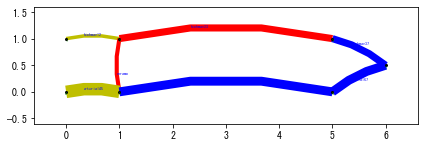

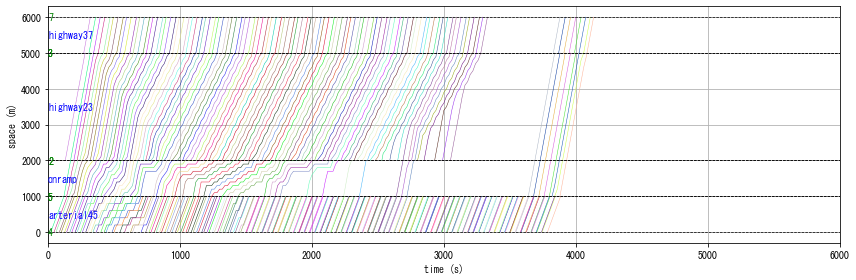

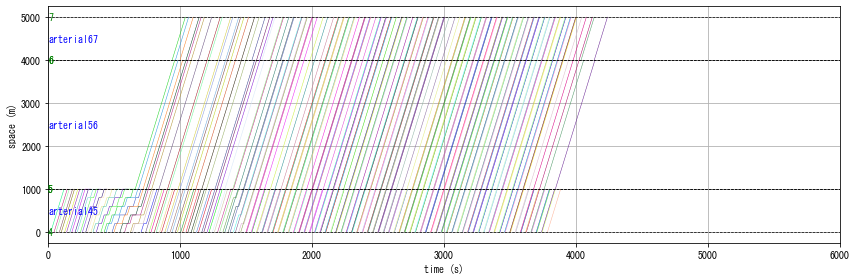

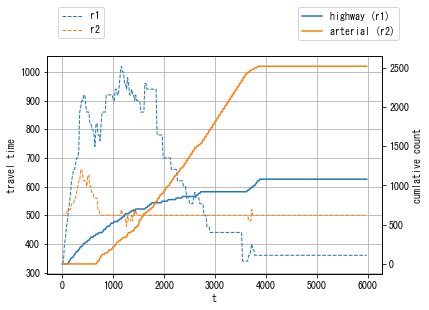

In [14]:
# DUO (default)

W_DUO = create_World()
W_DUO.exec_simulation()
W_DUO.analyzer.print_simple_stats(force_print=True)
df_DUO = W_DUO.analyzer.basic_to_pandas()

visualizaion_helper_function(W_DUO)

In DUO, you can see that many vehicles chose the highway route at the early stage of the simulation due to the fast maximum speed. It then caused a significant traffic jam, resulting a longer travel time. This demonstrates the myopic nature of DUO routing principle.

#### DUE

In [15]:
# DUE
solver_DUE = SolverDUE(create_World)
solver_DUE.solve(max_iter=100, print_progress=False)
W_DUE = solver_DUE.W_sol
W_DUE.analyzer.print_simple_stats(force_print=True)
df_DUE = W_DUE.analyzer.basic_to_pandas()

solving DUE...
DUE summary:
 total travel time: initial 4039200.0 -> average of last 25 runs 3195520.0
 number of potential route changes: initial 79.0 -> average of last 25 runs 67.5
 travel time gap: initial 13080.0 -> average of last 25 runs 4373.6
results:
 average speed:	 10.8 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 711.9 s
 average delay of trips:	 381.9 s
 delay ratio:			 0.536
 total distance traveled:	 23860000.0 m


results:
 average speed:	 10.8 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 711.9 s
 average delay of trips:	 381.9 s
 delay ratio:			 0.536
 total distance traveled:	 23860000.0 m


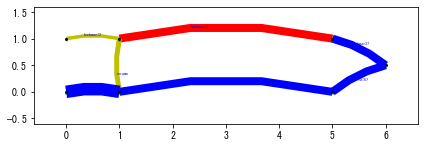

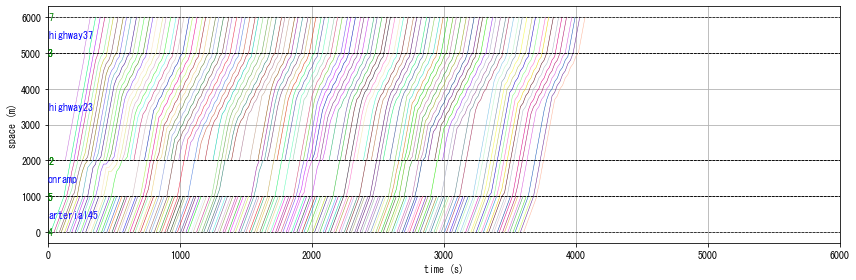

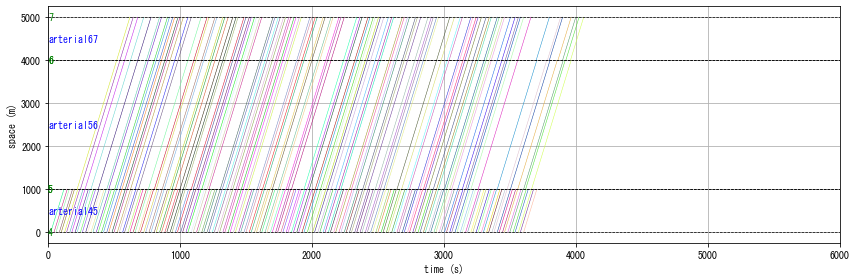

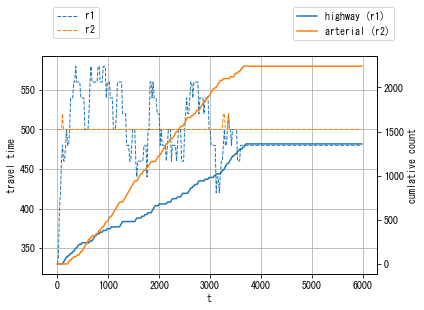

In [16]:
visualizaion_helper_function(W_DUE)

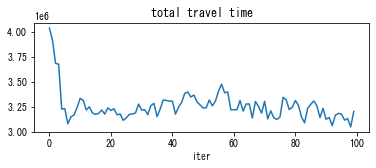

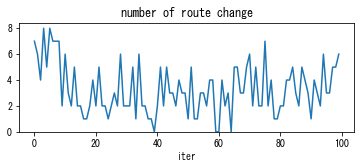

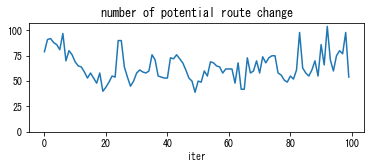

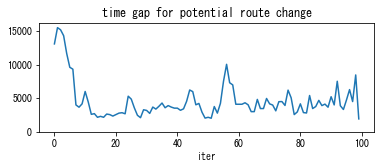

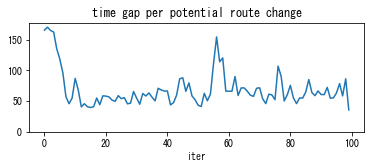

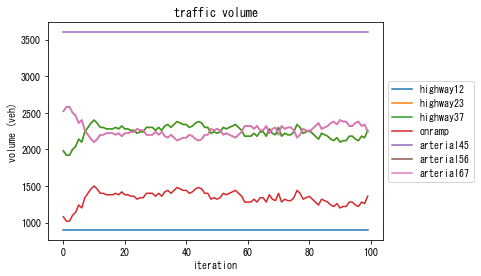

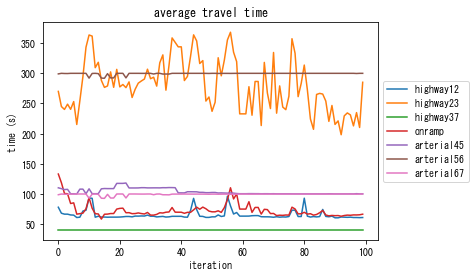

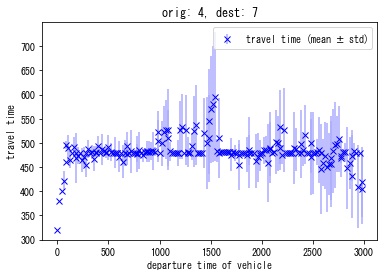

In [17]:
solver_DUE.plot_convergence()
solver_DUE.plot_link_stats()
solver_DUE.plot_vehicle_stats(orig="4", dest="7")

#### DSO

In [18]:
# DSO
solver_DSO = SolverDSO(create_World)
solver_DSO.solve(max_iter=100, print_progress=False, initial_solution_World=W_DUE)
W_DSO = solver_DSO.W_sol
W_DSO.analyzer.print_simple_stats(force_print=True)
df_DSO = W_DSO.analyzer.basic_to_pandas()



solving DSO...
DSO summary:
 total travel time: initial 3203600.0 -> last 2943600.0
results:
 average speed:	 12.0 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 654.1 s
 average delay of trips:	 324.1 s
 delay ratio:			 0.496
 total distance traveled:	 23740000.0 m


results:
 average speed:	 12.0 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 654.1 s
 average delay of trips:	 324.1 s
 delay ratio:			 0.496
 total distance traveled:	 23740000.0 m


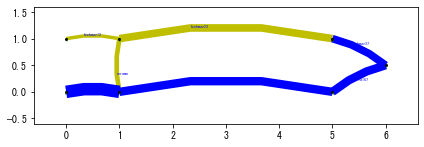

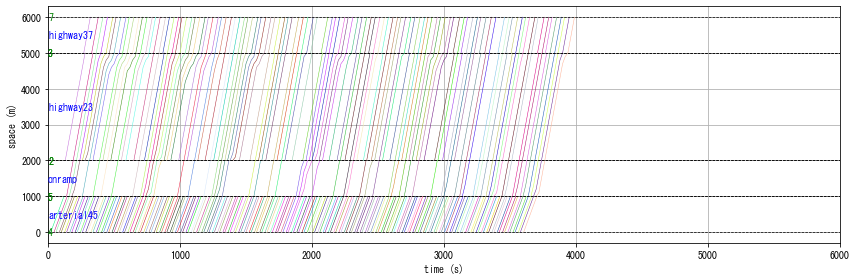

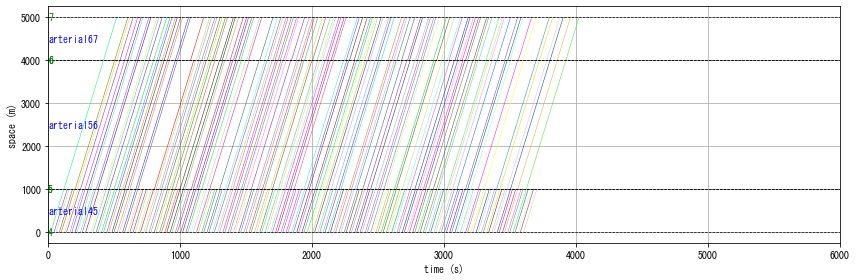

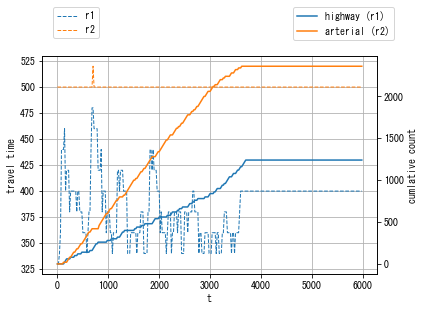

In [19]:

visualizaion_helper_function(W_DSO)

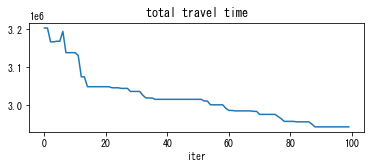

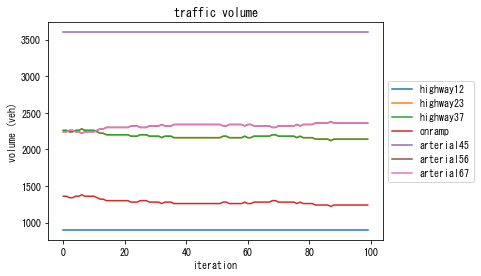

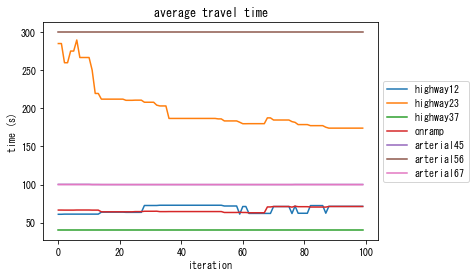

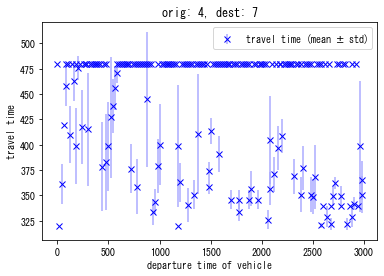

In [20]:

solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

#### DSO by Genetic Algorithm

Alternative solution method. This may be more practical than the above theoretical method, depending on the conditions.

In [21]:
# DSO by GA
solver_DSO_GA = SolverDSO_GA(create_World)
solver_DSO_GA.solve(max_iter=50, print_progress=False, pop_size=20)
W_DSO_GA = solver_DSO_GA.W_sol
W_DSO_GA.analyzer.print_simple_stats(force_print=True)
df_DSO_GA = W_DSO_GA.analyzer.basic_to_pandas()


solving DSO by GA...
DSO summary:
 total travel time: initial 3463200.0 -> last 2942800.0
results:
 average speed:	 12.0 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 654.0 s
 average delay of trips:	 324.0 s
 delay ratio:			 0.495
 total distance traveled:	 23620000.0 m


results:
 average speed:	 12.0 m/s
 number of completed trips:	 4500 / 4500
 average travel time of trips:	 654.0 s
 average delay of trips:	 324.0 s
 delay ratio:			 0.495
 total distance traveled:	 23620000.0 m


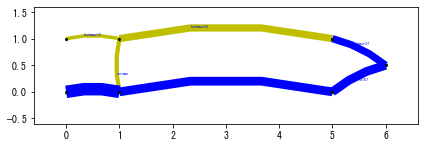

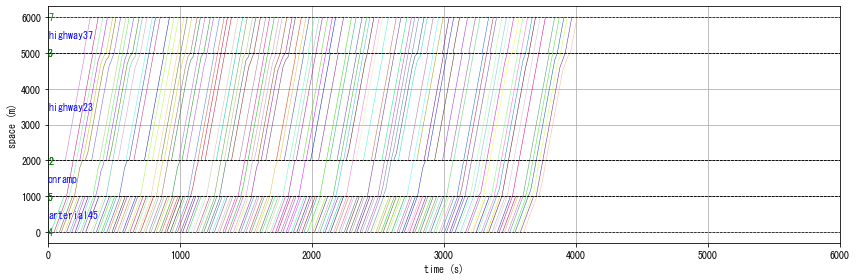

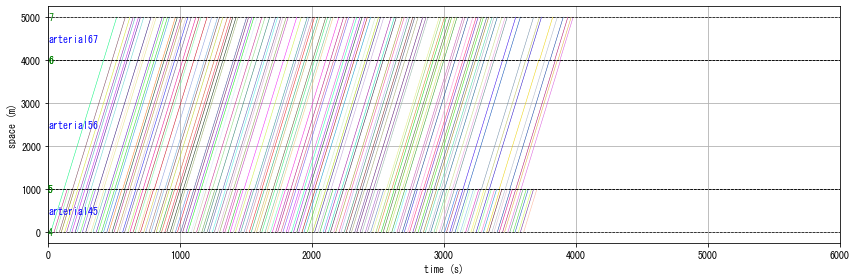

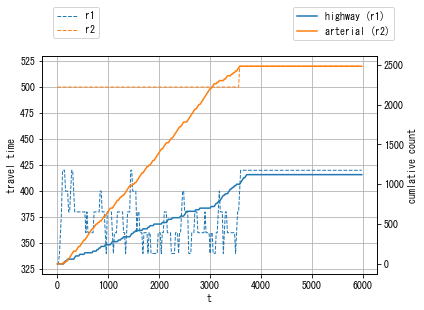

In [22]:
visualizaion_helper_function(W_DSO_GA)

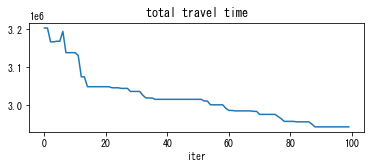

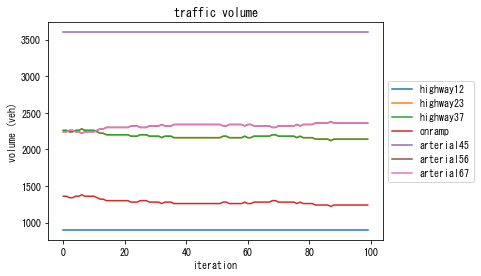

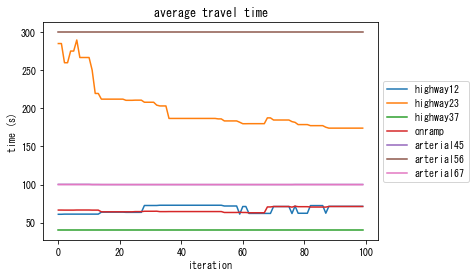

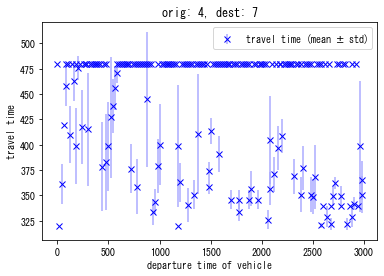

In [23]:
solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

#### Comparison

Comparison of 3 cases.

In [24]:

print("DUO")
display(df_DUO)
print("DUE")
display(df_DUE)
print("DSO")
display(df_DSO)
print("DSO by GA")
display(df_DSO_GA)


DUO


total_trips  completed_trips  total_travel_time  average_travel_time  \
0         4500             4500          4039200.0                897.6   

   total_delay  average_delay  
0    2554200.0          567.6

DUE


total_trips  completed_trips  total_travel_time  average_travel_time  \
0         4500             4500          3203600.0           711.911111   

   total_delay  average_delay  
0    1718600.0     381.911111

DSO


total_trips  completed_trips  total_travel_time  average_travel_time  \
0         4500             4500          2943600.0           654.133333   

   total_delay  average_delay  
0    1458600.0     324.133333

DSO by GA


total_trips  completed_trips  total_travel_time  average_travel_time  \
0         4500             4500          2942800.0           653.955556   

   total_delay  average_delay  
0    1457800.0     323.955556

### Large-scale scenario

Now we show larger example.

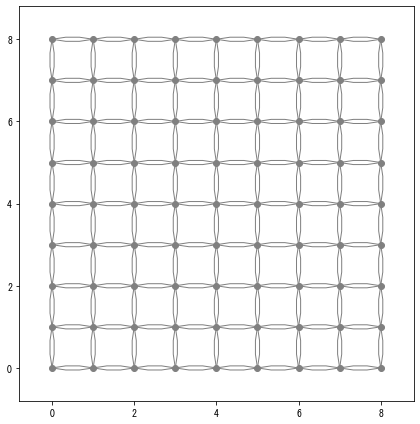

In [10]:
import uxsim
from uxsim import DTAsolvers

def create_World():
    # simulation world
    W = uxsim.World(
        name="",
        deltan=10,
        tmax=4800,
        duo_update_time=300,
        print_mode=0, save_mode=0, show_mode=1,
        random_seed=42,
    )

    # scenario
    #automated network generation
    #deploy nodes as an imax x jmax grid
    imax = 9
    jmax = 9
    id_center = 4
    nodes = {}
    for i in range(imax):
        for j in range(jmax):
            nodes[i,j] = W.addNode(f"n{(i,j)}", i, j, flow_capacity=1.6)

    #create links between neighborhood nodes
    links = {}
    for i in range(imax):
        for j in range(jmax):
            free_flow_speed = 10
            if i != imax-1:
                if j == id_center:
                    free_flow_speed = 20
                links[i,j,i+1,j] = W.addLink(f"l{(i,j,i+1,j)}", nodes[i,j], nodes[i+1,j], length=1000, free_flow_speed=free_flow_speed)
            if i != 0:
                if j == id_center:
                    free_flow_speed = 20
                links[i,j,i-1,j] = W.addLink(f"l{(i,j,i-1,j)}", nodes[i,j], nodes[i-1,j], length=1000, free_flow_speed=free_flow_speed)
            if j != jmax-1:
                if i == id_center:
                    free_flow_speed = 20
                links[i,j,i,j+1] = W.addLink(f"l{(i,j,i,j+1)}", nodes[i,j], nodes[i,j+1], length=1000, free_flow_speed=free_flow_speed)
            if j != 0:
                if i == id_center:
                    free_flow_speed = 20
                links[i,j,i,j-1] = W.addLink(f"l{(i,j,i,j-1)}", nodes[i,j], nodes[i,j-1], length=1000, free_flow_speed=free_flow_speed)

    #generate traffic demand between the boundary nodes
    demand_flow = 0.08
    demand_duration = 2400
    outer_ids = 3
    for n1 in [(0,j) for j in range(outer_ids, jmax-outer_ids)]:
        for n2 in [(imax-1,j) for j in range(outer_ids,jmax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
        for n2 in [(i,jmax-1) for i in range(outer_ids, imax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
    for n1 in [(i,0) for i in range(outer_ids, imax-outer_ids)]:
        for n2 in [(i,jmax-1) for i in range(outer_ids, imax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
        for n2 in [(imax-1,j) for j in range(outer_ids,jmax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
    
    return W

W = create_World()
W.change_print_mode(1)
W.show_network(network_font_size=0)

In this grid network, central links (links at x=4 and y=4) have faster free-flow speed of 20 m/s. The rest of links are with free-flow speed of 10 m/s. And the following four types of demands are generated:

- bottom edge (3 nodes at (3,0), (4,0), (5,0)) to top (3 nodes at (3,8), (4,8), (5,8))
- bottom edge to right
- left edge to top
- left to right

This is a deliberately inefficient setting that causes congestion. In a free-flowing condition, travelers tend to choose the central links. However, because traffic capacity of central links is limited, it may cause congestion although many other links are empty. To enhance system's performance, some travelers need to be distributed to slower links to efficiently utilize the network capacity.

First, let's compute DUO solution.

simulation setting:
 scenario name: 
 simulation duration:	 4800 s
 number of vehicles:	 6840 veh
 total road length:	 288000 m
 time discret. width:	 10 s
 platoon size:		 10 veh
 number of timesteps:	 480
 number of platoons:	 684
 number of links:	 288
 number of nodes:	 81
 setup time:		 3.46 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|     1380 vehs|   9.7 m/s|     0.16 s
    1200 s|     2240 vehs|   8.5 m/s|     0.42 s
    1800 s|     2860 vehs|   8.0 m/s|     0.63 s
    2400 s|     3030 vehs|   9.4 m/s|     0.87 s
    3000 s|     1290 vehs|   7.7 m/s|     1.04 s
    3600 s|        0 vehs|   0.0 m/s|     1.10 s
    4200 s|        0 vehs|   0.0 m/s|     1.14 s
    4800 s|        0 vehs|   0.0 m/s|     1.17 s
 simulation finished
results:
 average speed:	 9.6 m/s
 number of completed trips:	 6840 / 6840
 average travel time of trips:	 974.1 s
 average delay of trips:	 457.5 s
 delay ratio:			 0.4

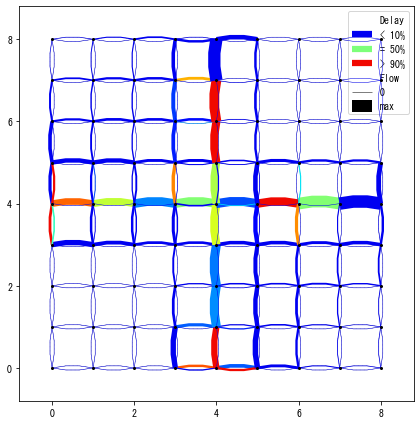

 generating animation...


  0%|          | 0/60 [00:00<?, ?it/s]

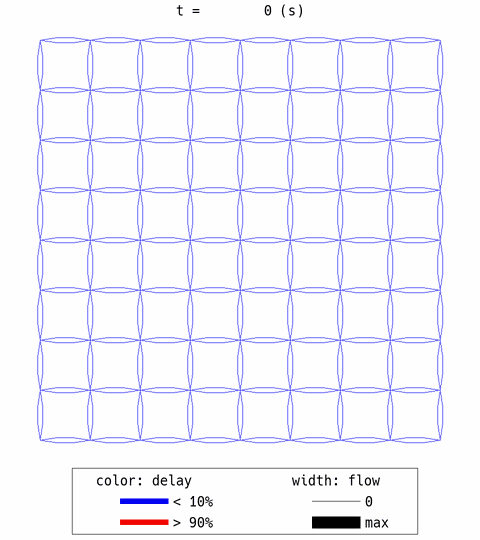

In [11]:
# execute simulation
W.exec_simulation()

# visualize
W.analyzer.print_simple_stats(force_print=True)
W.analyzer.network_average(network_font_size=0, legend=True)
W_DUO = W
df_DUO = W_DUO.analyzer.basic_to_pandas()

W_DUO.analyzer.network_anim(state_variables="flow_speed", figsize=4, animation_speed_inverse=20, timestep_skip=8, detailed=0, network_font_size=0, file_name="out/anim_DUO.gif")
uxsim.display_image_in_notebook("out/anim_DUO.gif")


The aforementioned expected behaviors are confirmed. Many travelers choose the central links first (thick width = high flow) and created congestion (red color = congestion). After that, some travelers avoided the center links. However, the overall efficiency is not good, with 0.470 delay ratio.

Now we compute DUE solution.

simulation setting (not finalized):
 scenario name: 
 simulation duration:	 4800 s
 number of vehicles:	 6840 veh
 total road length:	 288000 m
 time discret. width:	 10 s
 platoon size:		 10 veh
 number of timesteps:	 480.0
 number of platoons:	 684
 number of links:	 288
 number of nodes:	 81
 setup time:		 0.01 s
number of OD pairs: 6561, number of routes: 123134
solving DUE...
 iter 0: time gap: 142.5, potential route change: 32120, route change: 1350, total travel time:  6663000.0, delay ratio:  0.470
 iter 1: time gap: 96.6, potential route change: 26550, route change: 1260, total travel time:  6425700.0, delay ratio:  0.450
 iter 2: time gap: 89.8, potential route change: 26990, route change: 1070, total travel time:  6454600.0, delay ratio:  0.452
 iter 3: time gap: 77.4, potential route change: 24500, route change: 1070, total travel time:  6294300.0, delay ratio:  0.439
 iter 4: time gap: 67.0, potential route change: 25980, route change: 1210, total travel time:  6074200.0, 

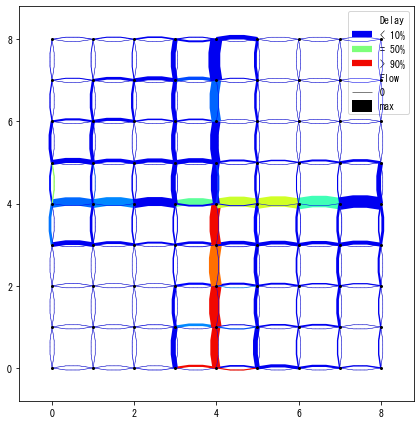

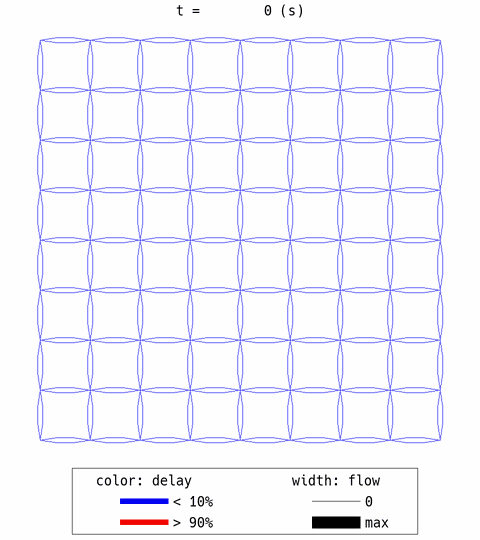

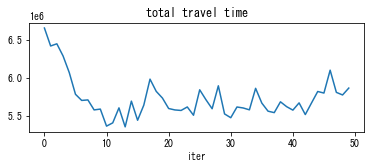

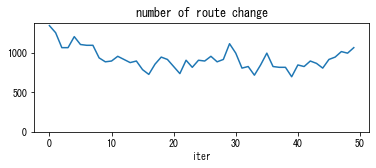

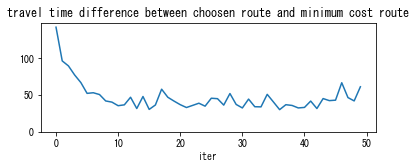

In [3]:
solver_DUE = DTAsolvers.SolverDUE(create_World)
solver_DUE.solve(max_iter=50, n_routes_per_od=20)

W_DUE = solver_DUE.W_sol
W_DUE.analyzer.print_simple_stats(force_print=True)
W_DUE.analyzer.network_average(network_font_size=0, legend=True)
df_DUE = W_DUE.analyzer.basic_to_pandas()

W_DUE.analyzer.network_anim(state_variables="flow_speed", figsize=4, animation_speed_inverse=20, timestep_skip=8, detailed=0, network_font_size=0, file_name="out/anim_DUE.gif")
uxsim.display_image_in_notebook("out/anim_DUE.gif")

solver_DUE.plot_convergence()

The algorithm successfully converged to a steady state, and it can be considered as a quasi-DUE state. 

According to "time gap" coefficient, the DUO solution has 142.5 s of time gap. This is the average time difference of route chosen by travelers and the actual minimum cost route. Since travelers in DUO are myopic, it is reasonable to have large time gap value. In the quasi-DUE state, the average time gap was reduced to 43.6 s. Travelers are much smarter than DUO. 

In the network animation, you can see that some travelers choose non-central links from the beginning. They anticipated that the central link would be congested and took action to avoid it in advance. 

As a result, the total delay ratio was reduced to 0.398 from 0.470 of DUO.

However, since travelers in DUE is still selfish, this is not optimal for the entire system.

Now, we compute DSO solution. This will take some time.

simulation setting:
 scenario name: 
 simulation duration:	 4800 s
 number of vehicles:	 6840 veh
 total road length:	 288000 m
 time discret. width:	 10 s
 platoon size:		 10 veh
 number of timesteps:	 480
 number of platoons:	 684
 number of links:	 288
 number of nodes:	 81
 setup time:		 426.93 s
init sol used
solving DSO by GA...
Generation 0
 total travel times: 5775900.0 5895500.0 5754500.0 5939800.0 6027800.0 5738500.0 5596400.0 5737800.0 5834900.0 5690300.0 5599700.0 5768500.0 5711600.0 5807600.0 5855300.0 5559800.0 5614200.0 5797200.0 5667200.0 5927300.0 5879700.0 5697400.0 5898200.0 5600400.0 5848900.0 6391700.0 7329400.0 6969200.0 6438500.0 6864600.0 6820900.0 6342100.0 6588700.0 6393100.0 6542900.0 6688200.0 7041400.0 6379700.0 6330900.0 6275400.0 6441800.0 6703100.0 6296700.0 6546100.0 6205700.0 6362200.0 6324000.0 6152700.0 7064600.0 7165700.0 
 Best fitness = -5559800.0, TTT = 5559800.0, completed trips: 6840
Generation 1
 total travel times: 5559800.0 5596400.0 5731000

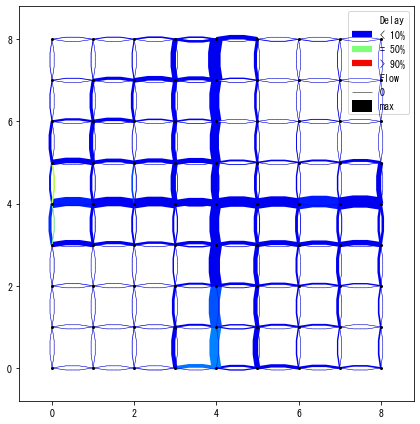

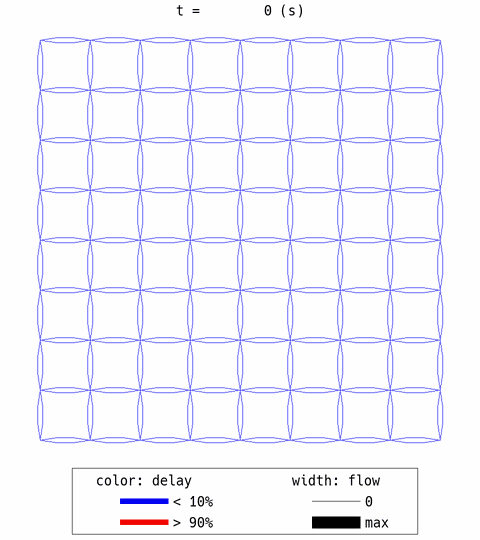

In [4]:
solver_DSO_GA = DTAsolvers.SolverDSO_GA(create_World)
solver_DSO_GA.solve(max_iter=50, pop_size=50, initial_solution_World=W_DUE)

W_DSO_GA = solver_DSO_GA.W_sol
W_DSO_GA.analyzer.print_simple_stats(force_print=True)
W_DSO_GA.analyzer.network_average(network_font_size=0, legend=True)
df_DSO_GA = W_DSO_GA.analyzer.basic_to_pandas()

W_DSO_GA.analyzer.network_anim(state_variables="flow_speed", figsize=4, animation_speed_inverse=20, timestep_skip=8, detailed=0, network_font_size=0, file_name="out/anim_DSO_GA.gif")
uxsim.display_image_in_notebook("out/anim_DSO_GA.gif")

Now the traffic situation is much better, with 0.305 delay ratio. According to the network animation, traffic was distributed to many routes. Most of traffic congestion observed in DUO/DUE solutions were eliminated.

Below is the summary of the 3 scenarios.

In [16]:
df_DUO['Name'] = 'DUO'
df_DUE['Name'] = 'DUE'
df_DSO_GA['Name'] = 'DSO'

df_combined = pd.concat([df_DUO, df_DUE, df_DSO_GA], ignore_index=True)
cols = ['Name'] + [col for col in df_combined.columns if col != 'Name']
df_combined = df_combined[cols]
display(df_combined)

Name  total_trips  completed_trips  total_travel_time  average_travel_time  \
0  DUO         6840             6840          6663000.0           974.122807   
1  DUE         6840             6840          5869600.0           858.128655   
2  DSO         6840             6840          5087300.0           743.757310   

   total_delay  average_delay  
0    3129000.0     457.456140  
1    2335600.0     341.461988  
2    1553300.0     227.090643

Below is some vehicle-level analysis

In [24]:
travel_time_per_vehicle_duo = [veh.travel_time for veh in W_DUO.VEHICLES.values()]
travel_time_per_vehicle_due = [veh.travel_time for veh in W_DUE.VEHICLES.values()]
travel_time_per_vehicle_dso = [veh.travel_time for veh in W_DSO_GA.VEHICLES.values()]

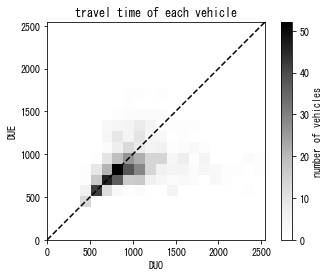

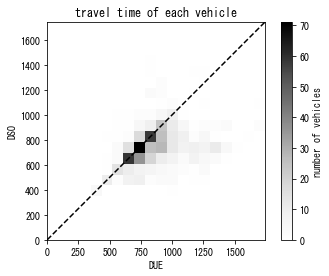

In [ ]:
figure()
subplot(111, aspect="equal")
title("travel time of each vehicle")
max_val = max(max(travel_time_per_vehicle_duo), max(travel_time_per_vehicle_due))
plot([0, max_val], [0, max_val], "k--")
hist2d(travel_time_per_vehicle_duo, travel_time_per_vehicle_due, range=[[0, max_val], [0, max_val]], bins=20, cmap="Greys")
colorbar().set_label("number of vehicles")
xlabel("DUO")
ylabel("DUE")
show()

figure()
subplot(111, aspect="equal")
title("travel time of each vehicle")
max_val = max(max(travel_time_per_vehicle_due), max(travel_time_per_vehicle_dso))
plot([0, max_val], [0, max_val], "k--")
hist2d(travel_time_per_vehicle_due, travel_time_per_vehicle_dso, range=[[0, max_val], [0, max_val]], bins=20, cmap="Greys")
colorbar().set_label("number of vehicles")
xlabel("DUE")
ylabel("DSO")
show()

In [57]:
route_of_vehicle_duo = [veh.traveled_route()[0] for veh in W_DUO.VEHICLES.values()]
route_of_vehicle_due = [veh.traveled_route()[0] for veh in W_DUE.VEHICLES.values()]
route_of_vehicle_dso = [veh.traveled_route()[0] for veh in W_DSO_GA.VEHICLES.values()]

In [58]:
print("number of vehicles that choose different routes in different scenarios")

changed = 0
total = 0
for i in lange(route_of_vehicle_duo):
    if route_of_vehicle_duo[i] != route_of_vehicle_due[i]:
        changed += W_DUO.DELTAN
    total += W_DUO.DELTAN
print("DUO vs DUE:", changed, "/", total)

changed = 0
total = 0
for i in lange(route_of_vehicle_duo):
    if route_of_vehicle_due[i] != route_of_vehicle_dso[i]:
        changed += W_DUO.DELTAN
    total += W_DUO.DELTAN
print("DUE vs DSO:", changed, "/", total)

number of vehicles that choose different routes in different scenarios
DUO vs DUE: 5380 / 6840
DUE vs DSO: 1540 / 6840
